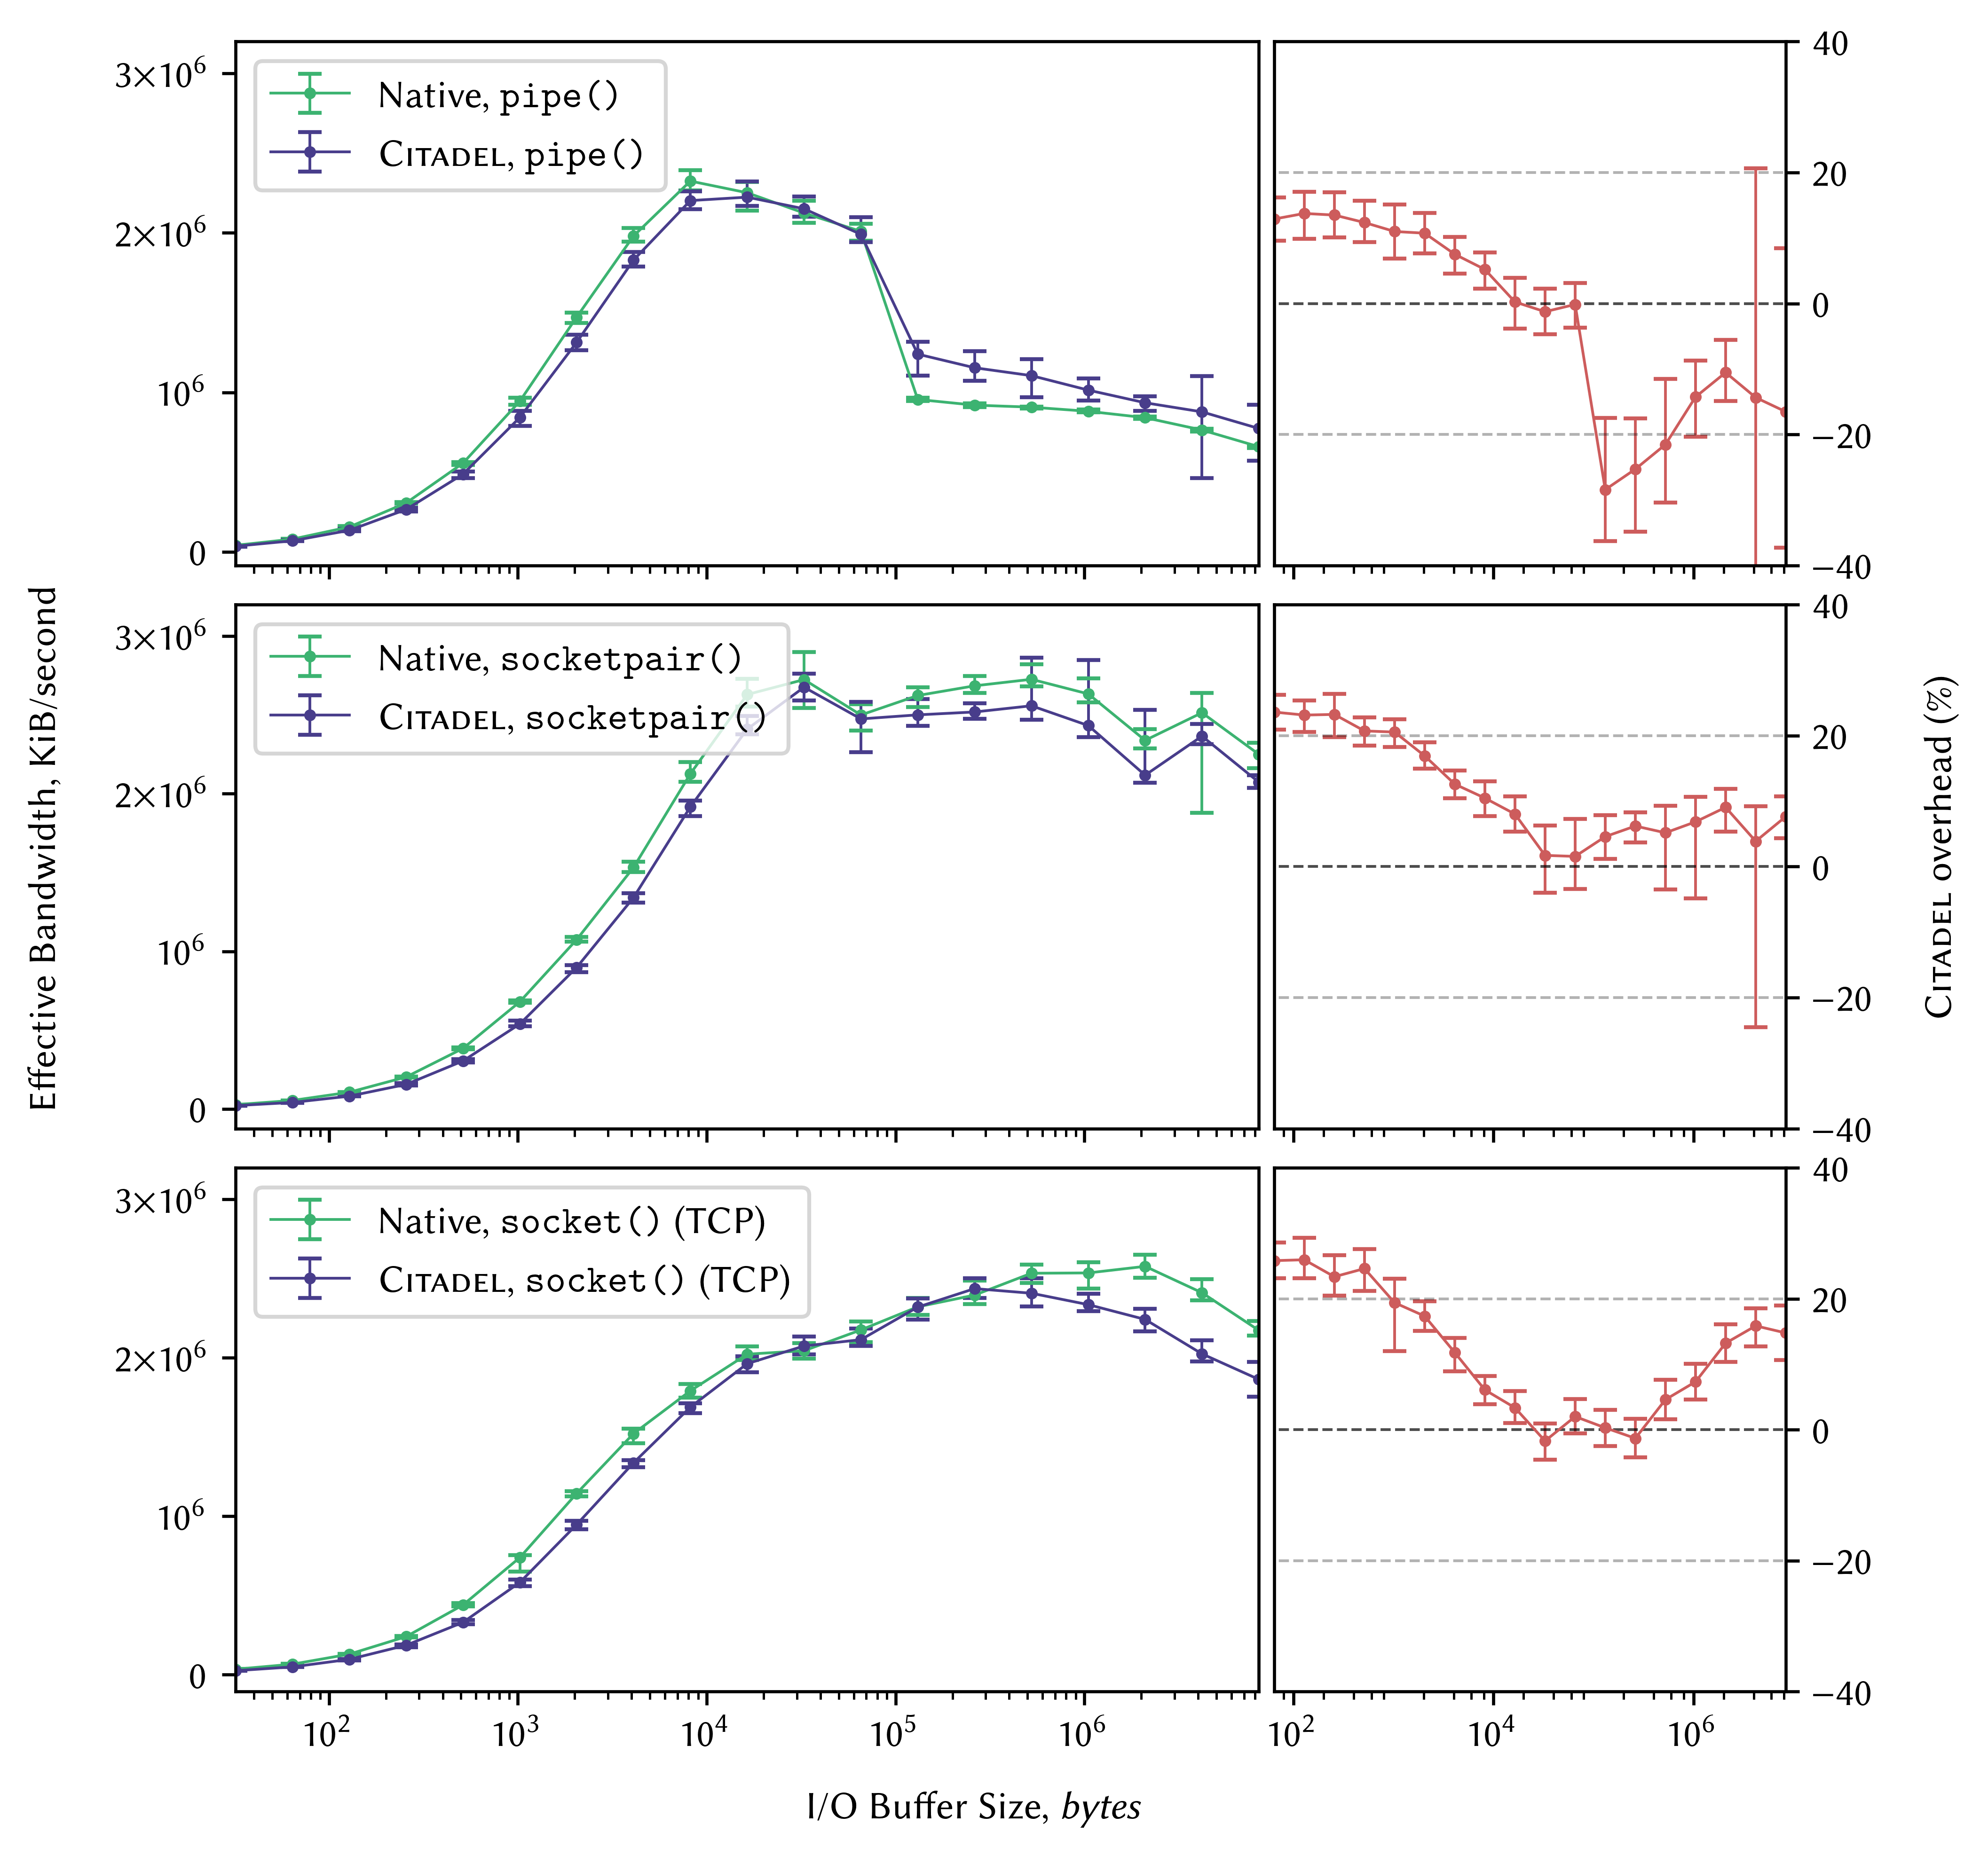

In [178]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import gridspec

mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['figure.figsize'] = 7,5
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage[tt=false]{libertine}\usepackage[libertine]{newtxmath}\usepackage{sfmath}\usepackage[T1]{fontenc}\usepackage{amsmath}'

file = "results2.log"


envs = ["vanilla", "citadel"]
env_names = { "vanilla": "Native", "citadel": "$\\textsc{Citadel}$" }
x_values = [2**i for i in range(5, 24)]
keys = []
y_value_sets = {}
ipc_subval = "2thread" # pipe, local, tcp ["1thread", "2thread", "2proc"]
colors = {
    "citadel": "darkslateblue",
    "vanilla": "mediumseagreen"
}
apps = [
#     ("io", ["r", "w"]), 
    ("ipc", ["pipe", "local", "tcp"])
#     ("ipc", ["pipe"])
]
line_names = {
    "pipe": "$\\texttt{pipe()}$",
    "local": "$\\texttt{socketpair()}$",
    "tcp": "$\\texttt{socket()}$ (TCP)",
    "r": "$\\texttt{read()}$",
    "w": "$\\texttt{write()}$"
}

rows = 0
for _a in apps:
    rows += len(_a[1])
    
mpl.rcParams['figure.figsize'] = 7,2.5*rows


def x_to_key(app, env, x, line):
    if app == "io":
        return "{}--b{}-t16777216-{}{}16MiB".format(env, x, line, "/opt/tainted/" if env == "citadel" else "-")
    else:
        return "{}--i{}-b{}-t16777216{}".format(env, line, x, ipc_subval)

for env in envs:
    y_env = {}
    for app in apps:
        y_apps = {}
        for line in app[1]:
            y_vals = []
            
            keys = [x_to_key(app[0], env, x, line) for x in x_values] 
            for key in keys:
                values = []
                with open(file, 'r') as f:
                    for l in f:
                        if l.startswith(key):
                            value = (l.replace("\n", "").split(",")[1])
                            values.append(float(value))

                y_vals.append(values)
    
#             print(line)
            y_apps[line] = y_vals  # data for particular line
        y_env[app[0]] = y_apps # data for particular app
    y_value_sets[env] = y_env

    
# print(y_value_sets)
#     y_value_sets -> citadel -> io -> r -> []

fig = plt.figure()
spec = gridspec.GridSpec(ncols=2, nrows=rows, figure=fig, width_ratios=[2,1])
spec.update(wspace=0.02, hspace=0.075)

# Plot first column.
counter = 0
shared_axis = False
for app in apps:
    for line in app[1]:
        if counter > 0:
            axis = fig.add_subplot(spec[counter, 0], sharex=shared_axis)
        else:
            axis = fig.add_subplot(spec[counter, 0])
            shared_axis = axis

        if counter < rows - 1:
            plt.setp(axis.get_xticklabels(), visible=False)
        else:
            pass
            
        for env in envs:
            upper = [np.percentile(y, 75)-np.percentile(y, 50) for y in y_value_sets[env][app[0]][line]]
            y_values = [np.percentile(y, 50) for y in y_value_sets[env][app[0]][line]]
            lower = [np.percentile(y, 50)-np.percentile(y, 25) for y in y_value_sets[env][app[0]][line]]
            
            (_, caps, _) = axis.errorbar(
                x_values, y_values, 
                yerr=[lower, upper],
                linewidth=0.7,
                color=colors[env],
                fmt='-o', markersize=2, capsize=3,
                linestyle="-", alpha=1,
                label="{}, {}".format(env_names[env], line_names[line])
            )
            for cap in caps:
                cap.set_markeredgewidth(1)
                
        

        axis.margins(x=0)
        # plt.legend([x[2] for x in __keys])
        # plt.xscale("log")
        f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
        g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
        axis.yaxis.set_major_formatter(mticker.FuncFormatter(g))
        loc = mticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
        axis.xaxis.set_major_locator(loc)
        axis.set_ylim(top=3.2 * 10**6)

        axis.set_xscale("log")
#         axis.set_ylabel("Bandwidth, $KiBps$")
        axis.legend(loc="upper left")
        
        counter += 1

# Plot second column.
# Calc. differences.
counter = 0
shared_axis = False
for app in apps:
        for line in app[1]:
            if counter > 0:
                axis = fig.add_subplot(spec[counter, 1], sharex=shared_axis)
            else:
                axis = fig.add_subplot(spec[counter, 1])
                shared_axis = axis
                
            if counter < rows - 1:
                plt.setp(axis.get_xticklabels(), visible=False)
            else:
                pass
            
            
            citadel = y_value_sets["citadel"][app[0]][line]
            vanilla = y_value_sets["vanilla"][app[0]][line]
            
            overhead = []
            upper = []
            lower = []
            length = max(len(citadel), len(vanilla))
            for i in range(length):
                cross_list = [(x, y) for x in citadel[i] for y in vanilla[i]]
                differences = [(y - x) / y for (x,y) in cross_list]
#                 print("{}, {}, {}".format(
#                     np.percentile(differences, 25),
#                     np.percentile(differences, 50),
#                     np.percentile(differences, 75)
#                 ))
                overhead.append(np.percentile(differences, 50))
                upper.append(np.percentile(differences, 70) - np.percentile(differences, 50))
                lower.append(np.percentile(differences, 50) - np.percentile(differences, 30))
                        
            
            overhead = [x*100 for x in overhead] # Percentage
            upper = [x*100 for x in upper] # Percentage
            lower = [x*100 for x in lower] # Percentage
                        
            (_, caps, _) = axis.errorbar(
                x_values, overhead, 
                yerr=[lower, upper],
                linewidth=0.7,
                color="indianred",
                fmt='-o', markersize=2, capsize=3,
                linestyle="-", alpha=1,
                label="{} {}".format(app[0], line)
            )
            for cap in caps:
                cap.set_markeredgewidth(1)
                
            axis.set_xscale("log")
            axis.yaxis.tick_right()
#             loc = mticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
#             axis.xaxis.set_major_locator(loc)
            axis.set_ylim(bottom=-40, top=40)
            axis.set_xticks([10**2, 10**4, 10**6])
            locmin = mticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
            axis.xaxis.set_minor_locator(locmin)
            axis.xaxis.set_minor_formatter(mticker.NullFormatter())
            axis.set_xlim(left=x_values[1], right=x_values[-1])
#             axis.legend(loc="upper right")
            
            axis.plot(
                [-100, 1000000000], [0,0], label="_nolegend_", 
                linestyle="--",
                alpha=0.7,
                color="black",
                linewidth=0.7
            )
            axis.plot(
                [-100, 1000000000], [20,20], label="_nolegend_", 
                linestyle="--",
                alpha=0.3,
                color="black",
                linewidth=0.7
            )
            axis.plot(
                [-100, 1000000000], [-20,-20], label="_nolegend_", 
                linestyle="--",
                alpha=0.3,
                color="black",
                linewidth=0.7
            )
                
            counter += 1

fig.subplots_adjust(bottom=0.1, right=0.91)
# fig.subplots_adjust(bottom=0.12, right=0.91)
fig.text(0.5, 0.04, 'I/O Buffer Size, $bytes$', ha='center')
fig.text(0.02, 0.5, 'Effective Bandwidth, KiB/second', va='center', rotation='vertical')
fig.text(0.98, 0.5, '$\\textsc{Citadel}$ overhead (\%)', va='center', rotation='vertical')
# plt.savefig("figures/ipc-2thread.pdf")
plt.show()            
            
